## Need to set up a notebook dependencies check section

In [2]:
try:
    setup_gcgs_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++
[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.
+++++++++++++++++++++++++++++++


## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import boto3.session
import sagemaker

gcgs_sess = boto3.session.Session() # Create our own session
gcgs_sess1 = boto3.Session() # MZ EXPERIMENT
gcgs_region = gcgs_sess.region_name
gcgs_sm_sess = sagemaker.Session(default_bucket="my-508-projects") # Assigned variable with sagemaker resources available
# ASSIGNED NEW DEFAULT BUCKET: "my-508-projects"
gcgs_bucket = gcgs_sm_sess.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=gcgs_region)
s31 = gcgs_sess.client(service_name="s3", region_name=gcgs_region) # MZ EXPERIMENT

print(gcgs_sess)
print(gcgs_sess1)
print(gcgs_region)
print(gcgs_sm_sess)
print(gcgs_bucket)
print(s3)
s31

Session(region_name='us-east-1')
Session(region_name='us-east-1')
us-east-1
my-508-projects


## Model code

In [4]:
!aws s3 cp 's3://my-508-projects/eng_mlcsv/eng_mlcsv2.csv' ./data_model/

download: s3://my-508-projects/eng_mlcsv/eng_mlcsv2.csv to data_model/eng_mlcsv2.csv


In [5]:
import csv
ml = pd.read_csv(
    r"./data_model/eng_mlcsv2.csv",
    engine = 'python',
    dtype={'NDC5_4':str}  # Must encode NDC with leading 0s as 'str'
)
ml.shape

(93902, 14)

In [6]:
ml = ml.dropna()
ml.shape

(91335, 14)

In [7]:
ml.dtypes

ptnt_pay_amt           int64
total_cost             int64
cost_per_day         float64
isgeneric            float64
TOT_RX_CST_AMT         int64
year                   int64
bene_sex_ident_cd      int64
bene_race_cd           int64
age_code               int64
esrd                   int64
region_code            int64
cont_enroll            int64
ccnum                  int64
high_ben               int64
dtype: object

In [8]:
ml.head(5)

,ptnt_pay_amt,total_cost,cost_per_day,isgeneric,TOT_RX_CST_AMT,year,bene_sex_ident_cd,bene_race_cd,age_code,esrd,region_code,cont_enroll,ccnum,high_ben
0,0,30,1.500000,1.0,30,2010,2,1,1,0,1,1,0,1
1,0,30,1.500000,1.0,30,2008,2,1,1,0,1,1,0,1
2,0,30,1.500000,1.0,30,2009,2,1,1,0,1,1,0,1
3,10,10,0.333333,1.0,0,2010,2,3,3,1,8,0,0,1
4,10,10,0.333333,1.0,0,2008,2,3,3,0,8,0,0,1


Text(0, 0.5, 'Generic Count')

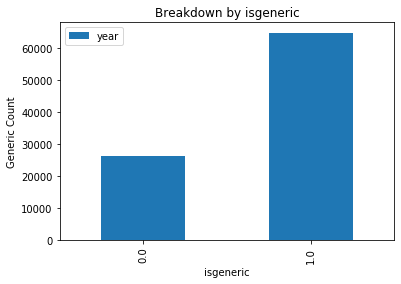

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline
#%config InlineBackend.figure_format='retina'

ml[['isgeneric','year']].groupby('isgeneric').count().plot(kind="bar", title="Breakdown by isgeneric")
plt.xlabel("isgeneric")
plt.ylabel("Generic Count")

In [11]:
# Balance the dataset down to the minority class
ml_grouped_by = ml.groupby(["isgeneric"]) 
ml_balanced = ml_grouped_by.apply(lambda x: x.sample(ml_grouped_by.size().min()).reset_index(drop=True))

ml_balanced = ml_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(ml_balanced.shape))

Shape of balanced dataframe (52872, 14)


In [12]:
ml_balanced.head(5)

,ptnt_pay_amt,total_cost,cost_per_day,isgeneric,TOT_RX_CST_AMT,year,bene_sex_ident_cd,bene_race_cd,age_code,esrd,region_code,cont_enroll,ccnum,high_ben
0,0,0,0.000000,0.0,0,2010,2,1,3,0,9,0,0,0
1,0,190,6.333334,0.0,190,2010,2,2,2,0,5,1,0,0
2,0,10,0.333333,0.0,10,2008,1,1,2,0,3,1,0,0
3,0,10,0.333333,0.0,10,2009,1,1,4,0,5,0,0,0
4,30,130,4.333334,0.0,100,2009,2,1,2,0,1,1,0,1


In [13]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
ml_train, ml_holdout = train_test_split(ml_balanced, test_size=0.30, stratify=ml_balanced["isgeneric"])

# Split holdout data into 50% validation and 50% test
ml_validation, ml_test = train_test_split(ml_holdout, test_size=0.50, stratify=ml_holdout["isgeneric"])

print(ml_train.shape)
print(ml_validation.shape)
ml_test.shape

(37010, 14)
(7931, 14)


(7931, 14)

In [14]:
filepath = "./data_model/ml_train.csv"
ml_train.to_csv(filepath, index=False, header=True)

# COPY CSVs TO S3

#import time

# The timestamp is for creating a fresh folder.  Disabled here so S3 will write over with newly engineered files.
#timestamp = int(time.time())
eng_df_s3_uri = gcgs_sm_sess.upload_data(bucket=gcgs_bucket, key_prefix="eng_model", path=filepath)
#eng_df_s3_uri = gcgs_sm_sess.upload_data(bucket=gcgs_bucket, key_prefix="eng_df-{}".format(timestamp), path=filepath)
print(eng_df_s3_uri)

# LIST DATA IN THE NEW S3 LOCATION

!aws s3 ls $eng_df_s3_uri

s3://my-508-projects/eng_model/ml_train.csv
2022-03-31 17:23:42    1573855 ml_train.csv
